In [3]:
#import packages
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
import gensim
import re
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
from gensim.models import FastText
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
import nltk
#nltk.download('punkt')


/var/folders/9q/pwqbdz21323f3j79799_2x7m0000gn/T/ipykernel_13126/2525775472.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [4]:
#reading in the cleaned dictionary
df = pd.read_csv('cleaned_dict.csv')

#replace commas with spaces
df['definition'] = df['definition'].str.replace(',', ' ')
#remove any non-alphabetic characters
df['definition'] = df['definition'].str.replace('[^a-zA-Z]', '')

#tokenize the definitions
df['definition'] = df['definition'].apply(word_tokenize)
#remove quotes from the words
df['definition'] = df['definition'].apply(lambda x: [word.replace("'", "") for word in x])

#train the word2vec model
model = Word2Vec(df['definition'], min_count=5, window=5, sg=0)

#save the model
model.save('codenames.model')

                                             Cluster    Clue
0                            [consequence, literary]  actual
1  [commander, profusion, mercurialize, clink, fa...    dole
2                                           [powder]    clay


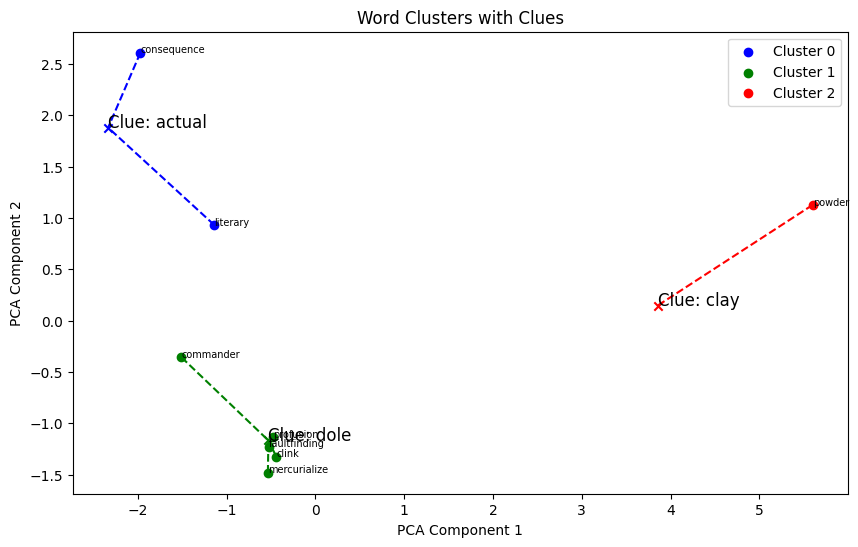

In [5]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def generate_clues(model, num_clusters, words_per_cluster):
    total_words = num_clusters * words_per_cluster
    # Ensure there are enough unique words in the model's vocabulary
    if len(model.wv.key_to_index) < total_words:
        raise ValueError(f"Model's vocabulary is too small. Requires at least {total_words} unique words.")

    # Select random words from the model's vocabulary
    random_words = random.sample(list(model.wv.key_to_index), total_words)

    # Convert words to vectors
    word_vectors = [model.wv[word] for word in random_words if word in model.wv]

    # Cluster the word vectors
    kmeans = KMeans(n_clusters=num_clusters, n_init=10)
    kmeans.fit(word_vectors)
    labels = kmeans.labels_

    # Find clusters
    clusters = {i: [] for i in range(num_clusters)}
    for word, label in zip(random_words, labels):
        if len(clusters[label]) < words_per_cluster:
            clusters[label].append(word)

    # Generating clues
    clues = {}
    for i in range(num_clusters):
        cluster_center = kmeans.cluster_centers_[i]
        closest_words = model.wv.similar_by_vector(cluster_center, topn=100)
        clue = None
        for word, similarity in closest_words:
            if word not in clusters[i]:
                clue = word
                break
        clues[i] = clue

    # Prepare the DataFrame
    df_clusters = pd.DataFrame({'Cluster': list(clusters.values()), 'Clue': list(clues.values())})
    return df_clusters



def plot_clusters_and_clues(model, df_clusters, num_clusters=5):
    pca = PCA(n_components=2)
    all_words = []
    for cluster in df_clusters['Cluster']:
        all_words.extend(cluster)
    all_words.extend(df_clusters['Clue'])

    # Get vectors for all words and apply PCA
    word_vectors = [model.wv[word] for word in all_words if word in model.wv]
    reduced_vectors = pca.fit_transform(word_vectors)

    # Split the vectors back into clusters and clues
    reduced_clusters = reduced_vectors[:len(all_words)-num_clusters]
    reduced_clues = reduced_vectors[len(all_words)-num_clusters:]

    # Plotting
    plt.figure(figsize=(10, 6))
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    for i, (cluster, clue) in enumerate(zip(df_clusters['Cluster'], df_clusters['Clue'])):
        cluster_vectors = [reduced_clusters[j] for j, word in enumerate(all_words[:len(all_words)-num_clusters]) if word in cluster]
        x = [v[0] for v in cluster_vectors]
        y = [v[1] for v in cluster_vectors]
        plt.scatter(x, y, c=colors[i % len(colors)], label=f'Cluster {i}')

        # Label each word in the cluster
        for word, vx, vy in zip(cluster, x, y):
            plt.text(vx, vy, word, fontsize=7)

        # Plot the clue
        clue_index = all_words.index(clue)
        clue_vector = reduced_clues[clue_index - len(all_words) + num_clusters]
        plt.scatter(clue_vector[0], clue_vector[1], c=colors[i % len(colors)], marker='x')
        plt.text(clue_vector[0], clue_vector[1], f'Clue: {clue}', fontsize=12)
        for vx, vy in zip(x, y):
            plt.plot([vx, clue_vector[0]], [vy, clue_vector[1]], c=colors[i % len(colors)], linestyle='--')

    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.title('Word Clusters with Clues')
    plt.legend()
    plt.show()

df_clues = generate_clues(model, 3, 5)
print(df_clues)
plot_clusters_and_clues(model, df_clues, 3)


In [3]:
#test the model is working by finding the most similar words to "animal"
print(model.wv.most_similar("animal"))

[('living', 0.8372555375099182), ('organ', 0.8342849016189575), ('vegetable', 0.811441957950592), ('growth', 0.8019890785217285), ('organism', 0.801365077495575), ('stomach', 0.7912545204162598), ('invertebrate', 0.7882574200630188), ('germ', 0.788128674030304), ('tissue', 0.7802934646606445), ('development', 0.7759531140327454)]


In [4]:
#test the similarity between words
print(model.wv.similarity('king', 'royalty'))

0.68695927


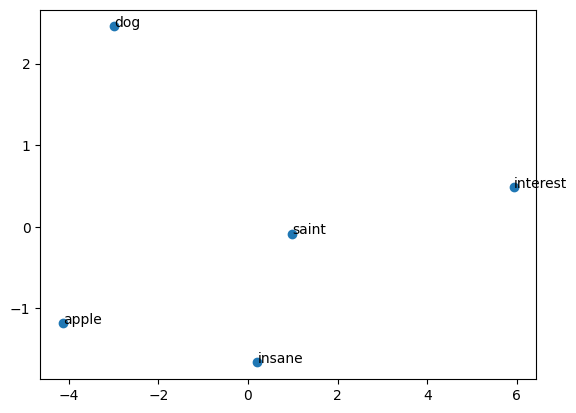

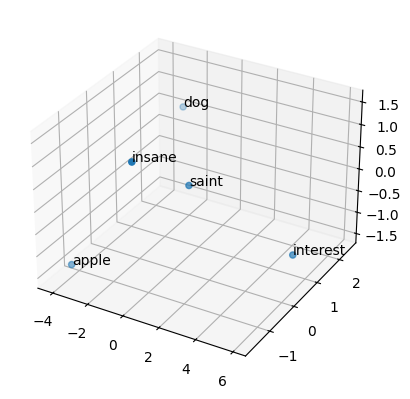

In [27]:
#import packages
import matplotlib.pyplot as plt          # pip install matplotlib
from sklearn.decomposition import PCA
#create a list of the words
#words = ['king', 'queen', 'peasant', 'royalty', 'poor']
words = ['apple', 'dog', 'saint', 'interest', 'insane']

#find the vectors for each word
vectors = [model.wv[word] for word in words]
#reduce the dimensions to 2
pca = PCA(n_components=2)
vectors_2d = pca.fit_transform(vectors)
#create a scatter plot
plt.scatter(vectors_2d[:, 0], vectors_2d[:, 1])
#label the points
for i, word in enumerate(words):
    plt.annotate(word, xy=(vectors_2d[i, 0], vectors_2d[i, 1]))
plt.show()

#now plot them in 3D
from mpl_toolkits.mplot3d import Axes3D
#create a list of the words
#words = ['king', 'queen', 'peasant', 'royalty', 'poor']
words = ['apple', 'dog', 'saint', 'interest', 'insane']

#find the vectors for each word
vectors = [model.wv[word] for word in words]
#reduce the dimensions to 3
pca = PCA(n_components=3)
vectors_3d = pca.fit_transform(vectors)
#create a scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(vectors_3d[:, 0], vectors_3d[:, 1], vectors_3d[:, 2])
#label the points
for i, word in enumerate(words):
    ax.text(vectors_3d[i, 0], vectors_3d[i, 1], vectors_3d[i, 2], word)
plt.show()

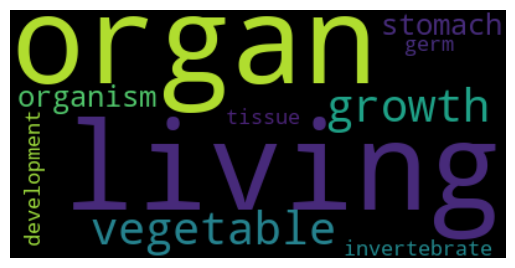

In [25]:
#make a wordcloud of the most similar words to "animal"
from wordcloud import WordCloud
#find the most similar words to "animal"
similar_words = model.wv.most_similar("animal")
#convert the similar words to a dictionary
wordcloud_dict = {word: similarity for word, similarity in similar_words}
#create the wordcloud
wordcloud = WordCloud()
wordcloud.generate_from_frequencies(wordcloud_dict)
#plot the wordcloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


TODO: Try to make a couple visualizations!

K-means clustering:
K-means clustering is used to group similar data points together through a process known as clustering. It is relatively easy to implement and understand, and only requires a few steps! 

How the general algorithm works!

1) Choose number of clusters (k) and initialize
2) Assign each data point to closest centroid
3) Recalculate centroids based on the mean of each cluster
4) Repeat steps 2 and 3 until the centroids no longer change
5) Now we have our final result. The centroids represent the center of each cluster 


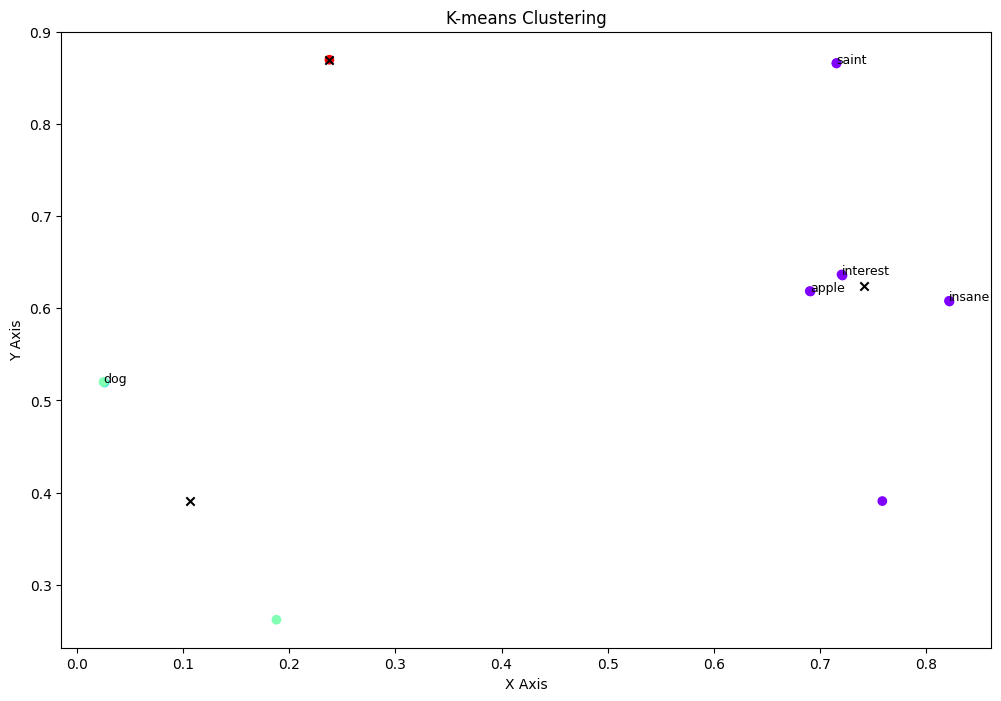

In [28]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Example dataset - Replace this with your actual data
data = np.random.rand(8, 2)  # 100 points in 2D

# Step 1: Choose the number of clusters (k) and initialize
k = 3  # for example, we choose 3 clusters
kmeans = KMeans(n_clusters=k)

# Step 2: Assign each data point to the closest centroid
kmeans.fit(data)

# The following steps are internally managed by the fit method
# Step 3: Recalculate centroids based on the mean of each cluster
# Step 4: Repeat steps 2 and 3 until the centroids no longer change

# Step 5: Obtain the final result - the centroids represent the center of each cluster
centroids = kmeans.cluster_centers_
labels = kmeans.labels_

plt.figure(figsize=(12, 8))
for i, word in enumerate(words):
    plt.scatter(data[i, 0], data[i, 1], c=[plt.cm.rainbow(labels[i]/k)])
    plt.text(data[i, 0], data[i, 1], word, fontsize=9)


# Plotting the results
plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='rainbow')
plt.scatter(centroids[:, 0], centroids[:, 1], color='black', marker='x')
plt.title('K-means Clustering')
plt.xlabel('X Axis')
plt.ylabel('Y Axis')
plt.show()
